In [14]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import csv

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM Group creator

**Context**
<br>
The POPs Team wants to run some tests with different partners to see which level of aggressiveness works best. In order to do this, they need to divide their sample data into two groups - a CONTROL group and a TREAT group.To resolve the question of what is the best grouping, we use this script for each partner. A fake synthtetic control analysis is used to decide which is the best partners' grouping. After an imaginary TREATMENT we perform a synthetic control analysis to the CONTROL and TREAT group. The least difference between CONTROL and TREAT is the group that we consider to be the best predictor.

**Approach**
 - highest p value
 - least MSE
- 80% TREAT, 20% CONTROL
- I use 6 complete weeks of data, using 2 to evaluate changes

Read .csv file from config_prod file for d_stores

In [15]:
# Params
group_name = ['CARR_ES', 'CARR_IT', 'CARR_GE', 'CONT_PT', 'NIKO_GE']

# Read csv
d_stores = rw.csv_read_file('config.csv')
cond = d_stores['group_name'].isin(group_name)
d_stores = d_stores[cond][['country_code','group_name','store_address_id']]
d_stores

#Report
print('There are {} distinct countries'.format(d_stores['country_code'].nunique()))
print('There are {} distinct group names'.format(d_stores['group_name'].nunique()))
print('There are {} distinct store addresses'.format(d_stores['store_address_id'].nunique()))

grouped_stores = d_stores.groupby('group_name')['store_address_id'].nunique().reset_index()
grouped_stores

There are 4 distinct countries
There are 5 distinct group names
There are 949 distinct store addresses


,group_name,store_address_id
0,CARR_ES,262
1,CARR_GE,29
2,CARR_IT,408
3,CONT_PT,193
4,NIKO_GE,57


Query the information in d_pna to enrich the d_stores

In [16]:
start_date = '2023-05-15'; end_date = '2023-07-02'

# All store addresses in d_stores in XXX1,XXX2,XXX3... format
store_addresses = ",".join(str(val) for val in d_stores['store_address_id'].unique().tolist())

# Params
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query
query = query_engines.QueryEngines(
    query='SPM/SPM_group_creator.sql', 
    del1='--v2', 
    del2='--end_v2',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()

#Report
print('There are {} distinct dates'.format(d_pna['order_descriptors.order_activated_local_date'].nunique()))
print('There are {} distinct store_addresses'.format(d_pna['order_descriptors.store_address_id'].nunique()))
print('There are {} distinct number of products_with_pna'.format(d_pna['number_of_products_with_pna'].sum()))
print('There are {} distinct number of placed products'.format(d_pna['number_of_placed_products'].sum()))
print('There are {} distinct number of orders'.format(d_pna['number_of_orders'].sum()))

There are 49 distinct dates
There are 810 distinct store_addresses
There are 152167 distinct number of products_with_pna
There are 1917397 distinct number of placed products
There are 248680 distinct number of orders


Merge the queried info from d_pna to d_stores dataframe

In [17]:
# We only keep the stores that had sales with an inner join
d_inner = pd.merge(d_stores,d_pna
                      ,left_on=['store_address_id']
                      ,right_on=['order_descriptors.store_address_id']
                      ,how='inner').drop('order_descriptors.store_address_id', axis=1)

# Rename the date column
d_inner = d_inner.rename(columns={'order_descriptors.order_activated_local_date': 'date'})

# Report
d_inner.groupby(by='group_name').agg({
    'store_address_id': 'nunique'
    ,'date': ['min', 'max', 'nunique']
    ,'number_of_products_with_pna': 'sum'
    ,'number_of_placed_products': 'sum'
    ,'number_of_orders':'sum'
    ,'number_of_delivered_orders':'sum'
    ,'total_quantity_placed':'sum'
    ,'products_value_placed':'sum'
})

store_address_id        date                      \
                    nunique         min         max nunique   
group_name                                                    
CARR_ES                 243  2023-05-15  2023-07-02      49   
CARR_GE                  23  2023-05-15  2023-07-02      49   
CARR_IT                 321  2023-05-15  2023-07-02      49   
CONT_PT                 182  2023-05-15  2023-07-02      49   
NIKO_GE                  41  2023-05-15  2023-07-02      49   

           number_of_products_with_pna number_of_placed_products  \
                                   sum                       sum   
group_name                                                         
CARR_ES                          45250                    582250   
CARR_GE                           6313                    114835   
CARR_IT                          35782                    541761   
CONT_PT                          59774                    547317   
NIKO_GE                           5048                    131234   

           number_of_orders number_of_delivered_orders total_quantity_placed  \
                        sum                        sum                   sum   
group_name                                                                     
CARR_ES               71881                      69717                879125   
CARR_GE               15583                      15022                174633   
CARR_IT               70771                      68089                751051   
CONT_PT               69075                      64934                687711   
NIKO_GE               21370                      20256                212375   

           products_value_placed  
                             sum  
group_name                        
CARR_ES             1.918422e+06  
CARR_GE             3.165625e+05  
CARR_IT             1.928194e+06  
CONT_PT             1.556417e+06  
NIKO_GE             3.077627e+05

# Change partner

Do the Nth iterations to split the data

In [18]:
# Params
N = 50
p_control = 0.2 # Probability that to be control gropup
start_pre = "2023-05-15"
end_pre = "2023-06-18"
start_post = "2023-06-19"
end_post = "2023-07-02"
group_name = 'CONT_PT'

# Small calculations from params
p_treat = 1-p_control # Probability to be treat group
d_filtered = d_inner[d_inner['group_name'] == group_name] 

# We take all the store addresses unique and build a DF of 1 column with it
series = pd.Series(d_filtered['store_address_id'].unique())
df_groups = pd.DataFrame({'store_address_id': series})

# Create an empty DataFrame to store the results
results_dict = {}

for iteration in range(N):
    
    # To each store address add a label of Treat or Control
    labels = ['Treat', 'Control']
    df_groups['Group'] = np.random.choice(labels, size=len(df_groups), p=[p_treat, p_control])
    df_groups_json = df_groups.to_json(orient='split') # Info of the dataframe in a json format to later be used
    d_filtered_w_groups = pd.merge(d_filtered, df_groups, on='store_address_id', how='left')
    
    # Data period range
    pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
    post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

    # Group by and compute the metrics for synth format
    df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'
                                                            ,'number_of_placed_products'
                                                            ,'number_of_orders'
                                                            ,'number_of_delivered_orders'
                                                            ,'total_quantity_placed'
                                                            ,'products_value_placed'
                                                            ].sum().reset_index()
    df_synth_format['perc_products_pna'] = df_synth_format['number_of_products_with_pna']/df_synth_format['number_of_placed_products']
    df_synth_format['avg_UIPO'] = df_synth_format['number_of_placed_products']/df_synth_format['number_of_orders']
    
    ####################################################################
    # Model for Perc Products PNA
    variable_name='perc_products_pna'
    
    # Initialize the dictionary 
    if variable_name not in results_dict:
        results_dict[variable_name] = {}
    
    # Pivot desired columns to conduct causalimpact analysis
    df_pivot = df_synth_format.pivot(index='date', columns='Group', values='perc_products_pna').reindex(columns=['Treat', 'Control'])
    df_pivot.columns = ['Treat_perc_products_pna', 'Control_perc_products_pna']  # Rename the first columns
    df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
    df_pivot['Control_number_of_delivered_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_delivered_orders').reindex(columns=['Control'])
    df_pivot['Control_avg_UIPO'] = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Control'])
    df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format
    
    # Initialize the dictionary 
    if variable_name not in results_dict:
        results_dict[variable_name] = {}
    
    # Model
    model = ci.CausalImpact(df_pivot[['Treat_perc_products_pna'
                                    ,'Control_perc_products_pna'
                                    ,'Control_number_of_orders'
                                    ,'Control_number_of_delivered_orders'
                                    ,'Control_avg_UIPO']],pre_period,post_period)
    
    # MSE
    # mse_post_period = ((df_pivot.loc[post_period[0]:post_period[1], 'Treat_perc_products_pna'] - model.inferences.loc[post_period[0]:post_period[1], 'preds']) ** 2).mean()
    
    # SMAPE
    # pre
    pre_baseline_error = abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_perc_products_pna'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    pre_mase_post_period = (abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_perc_products_pna'] - model.inferences.loc[pre_period[0]:pre_period[1], 'preds'])).mean() / pre_baseline_error
    # post
    post_baseline_error = abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_perc_products_pna'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    post_mase_post_period = (abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_perc_products_pna'] - model.inferences.loc[post_period[0]:post_period[1], 'preds'])).mean() / post_baseline_error
    
    # Store the results
    results_dict[variable_name][iteration] = {'df_groups_json': df_groups_json, 'pre_mase_post_period': pre_mase_post_period, 'post_mase_post_period': post_mase_post_period, 'model': model}
    
    ####################################################################
    # Model for avg_UIPO
    variable_name='avg_UIPO'
    
    # Initialize the dictionary 
    if variable_name not in results_dict:
        results_dict[variable_name] = {}
        
    # Pivot desired columns to conduct causalimpact analysis
    df_pivot = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Treat', 'Control'])
    df_pivot.columns = ['Treat_avg_UIPO', 'Control_avg_UIPO']  # Rename the first columns
    df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
    df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
    df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
    df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
    df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format
    
    # Model
    model = ci.CausalImpact(df_pivot[['Treat_avg_UIPO'
                                    ,'Control_avg_UIPO'
                                    ,'Control_number_of_orders'
                                    ,'Control_number_of_products_with_pna'
                                    ,'Control_total_quantity_placed'
                                    ,'Control_products_value_placed']],pre_period,post_period)
    
    # MSE
    # mse_post_period = ((df_pivot.loc[post_period[0]:post_period[1], 'Treat_perc_products_pna'] - model.inferences.loc[post_period[0]:post_period[1], 'preds']) ** 2).mean()
    
    # SMAPE
    # pre
    pre_baseline_error = abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_avg_UIPO'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    pre_mase_post_period = (abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_avg_UIPO'] - model.inferences.loc[pre_period[0]:pre_period[1], 'preds'])).mean() / pre_baseline_error
    # post
    post_baseline_error = abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_avg_UIPO'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    post_mase_post_period = (abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_avg_UIPO'] - model.inferences.loc[post_period[0]:post_period[1], 'preds'])).mean() / post_baseline_error
    
    # Store the results
    results_dict[variable_name][iteration] = {'df_groups_json': df_groups_json, 'pre_mase_post_period': pre_mase_post_period, 'post_mase_post_period': post_mase_post_period, 'model': model}
    
    ####################################################################
    # Model for number_of_orders
    variable_name='number_of_orders'
    
    # Initialize the dictionary 
    if variable_name not in results_dict:
        results_dict[variable_name] = {}
        
    # Pivot desired columns to conduct causalimpact analysis
    df_pivot = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Treat', 'Control'])
    df_pivot.columns = ['Treat_number_of_orders', 'Control_number_of_orders']  # Rename the first columns
    df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
    df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
    df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
    df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format
    
    # Model
    model = ci.CausalImpact(df_pivot[['Treat_number_of_orders'
                                    ,'Control_number_of_orders'
                                    ,'Control_number_of_products_with_pna'
                                    ,'Control_total_quantity_placed'
                                    ,'Control_products_value_placed']],pre_period,post_period)
    
    # MSE
    # mse_post_period = ((df_pivot.loc[post_period[0]:post_period[1], 'Treat_perc_products_pna'] - model.inferences.loc[post_period[0]:post_period[1], 'preds']) ** 2).mean()
    
    # SMAPE
    # pre
    pre_baseline_error = abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_number_of_orders'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    pre_mase_post_period = (abs(df_pivot.loc[pre_period[0]:pre_period[1], 'Treat_number_of_orders'] - model.inferences.loc[pre_period[0]:pre_period[1], 'preds'])).mean() / pre_baseline_error
    # post
    post_baseline_error = abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_number_of_orders'].diff()).mean()  # Calculate the mean absolute error of the baseline model    
    post_mase_post_period = (abs(df_pivot.loc[post_period[0]:post_period[1], 'Treat_number_of_orders'] - model.inferences.loc[post_period[0]:post_period[1], 'preds'])).mean() / post_baseline_error
    
    # Store the results
    results_dict[variable_name][iteration] = {'df_groups_json': df_groups_json, 'pre_mase_post_period': pre_mase_post_period, 'post_mase_post_period': post_mase_post_period, 'model': model}
    
    warnings.filterwarnings('ignore')

Comparison of MASE

In [24]:
variable_name = 'perc_products_pna'

# Initiate df
keys = sorted(results_dict[variable_name].keys())  # Sort the keys in ascending order
df = pd.DataFrame(columns=['Key', 'Pre MASE', 'Post MASE'])

# Populate the DataFrame
for key in keys:
    pre_mase = results_dict[variable_name][key]['pre_mase_post_period']
    post_mase = results_dict[variable_name][key]['post_mase_post_period']
    df = df.append({'Key': key, 'Pre MASE': pre_mase, 'Post MASE': post_mase}, ignore_index=True)

df['rank_pre'] = df['Pre MASE'].rank()
df['rank_post'] = df['Post MASE'].rank()

# Display the DataFrame
df_perc_products_pna = df.copy()
df_perc_products_pna

,Key,Pre MASE,Post MASE,rank_pre,rank_post
0,0.0,0.839664,1.008212,34.0,9.0
1,1.0,0.880069,0.889115,37.0,3.0
2,2.0,0.745958,0.916413,15.0,4.0
3,3.0,0.704721,1.125379,9.0,18.0
4,4.0,0.851816,1.501171,35.0,37.0
5,5.0,0.752466,1.077761,21.0,13.0
6,6.0,0.751676,2.234450,19.0,49.0
7,7.0,0.969201,1.444673,44.0,33.0
8,8.0,0.672673,1.269593,6.0,22.0
9,9.0,0.949064,1.622079,43.0,40.0


In [25]:
variable_name = 'avg_UIPO'

# Initiate df
keys = sorted(results_dict[variable_name].keys())  # Sort the keys in ascending order
df = pd.DataFrame(columns=['Key', 'Pre MASE', 'Post MASE'])

# Populate the DataFrame
for key in keys:
    pre_mase = results_dict[variable_name][key]['pre_mase_post_period']
    post_mase = results_dict[variable_name][key]['post_mase_post_period']
    df = df.append({'Key': key, 'Pre MASE': pre_mase, 'Post MASE': post_mase}, ignore_index=True)

df['rank_pre'] = df['Pre MASE'].rank()
df['rank_post'] = df['Post MASE'].rank()

# Display the DataFrame
df_avg_UIPO = df.copy()
df_avg_UIPO

,Key,Pre MASE,Post MASE,rank_pre,rank_post
0,0.0,0.554470,0.528793,8.0,3.0
1,1.0,0.739772,1.044565,45.0,49.0
2,2.0,0.560233,0.728144,9.0,18.0
3,3.0,0.666619,0.804832,30.0,25.0
4,4.0,0.622463,0.903547,17.0,41.0
5,5.0,0.709725,0.880878,42.0,38.0
6,6.0,0.685916,1.009213,37.0,48.0
7,7.0,0.718341,0.563787,44.0,5.0
8,8.0,0.708052,0.884345,41.0,39.0
9,9.0,0.793928,0.852294,50.0,36.0


In [26]:
variable_name = 'number_of_orders'

# Initiate df
keys = sorted(results_dict[variable_name].keys())  # Sort the keys in ascending order
df = pd.DataFrame(columns=['Key', 'Pre MASE', 'Post MASE'])

# Populate the DataFrame
for key in keys:
    pre_mase = results_dict[variable_name][key]['pre_mase_post_period']
    post_mase = results_dict[variable_name][key]['post_mase_post_period']
    df = df.append({'Key': key, 'Pre MASE': pre_mase, 'Post MASE': post_mase}, ignore_index=True)

df['rank_pre'] = df['Pre MASE'].rank()
df['rank_post'] = df['Post MASE'].rank()

# Display the DataFrame
df_number_of_orders = df.copy()
df_number_of_orders

,Key,Pre MASE,Post MASE,rank_pre,rank_post
0,0.0,0.340607,0.411008,7.0,7.0
1,1.0,0.359380,0.388808,13.0,5.0
2,2.0,0.438055,0.442648,41.0,12.0
3,3.0,0.357837,0.488329,12.0,20.0
4,4.0,0.372825,0.454039,17.0,14.0
5,5.0,0.401392,0.893724,27.0,48.0
6,6.0,0.390015,0.732092,22.0,43.0
7,7.0,0.418987,0.582277,33.0,29.0
8,8.0,0.423655,0.763535,36.0,44.0
9,9.0,0.427308,0.668434,39.0,37.0


In [27]:
# Merge all the dataframes
df_m = pd.merge(df_perc_products_pna,df_avg_UIPO,on='Key',suffixes=("_ppp", "_uipo"))
df_agg = pd.merge(df_m,df_number_of_orders, on='Key')

# The last merge columns must be renamed 
df_agg.rename(columns={'rank_pre':'rank_pre_norders'
                       ,'rank_post':'rank_post_norders'}, inplace=True)

df_agg['rank_post_agg'] = df_agg['rank_post_ppp'] + df_agg['rank_post_uipo']+df_agg['rank_post_norders']
df_agg['rank_pre_agg'] = df_agg['rank_pre_ppp'] + df_agg['rank_pre_uipo']+df_agg['rank_pre_norders']
df_agg[[
    'rank_post_agg'
    ,'rank_post_ppp'
    ,'rank_post_uipo'
    ,'rank_post_norders'
]].sort_values(by='rank_post_agg', ascending=True)


,rank_post_agg,rank_post_ppp,rank_post_uipo,rank_post_norders
0,19.0,9.0,3.0,7.0
17,31.0,8.0,17.0,6.0
2,34.0,4.0,18.0,12.0
34,37.0,5.0,4.0,28.0
28,41.0,11.0,7.0,23.0
16,43.0,2.0,8.0,33.0
30,44.0,7.0,2.0,35.0
14,45.0,6.0,24.0,15.0
29,47.0,10.0,26.0,11.0
15,47.0,15.0,1.0,31.0


Plot models and p value

0.22877122877122877


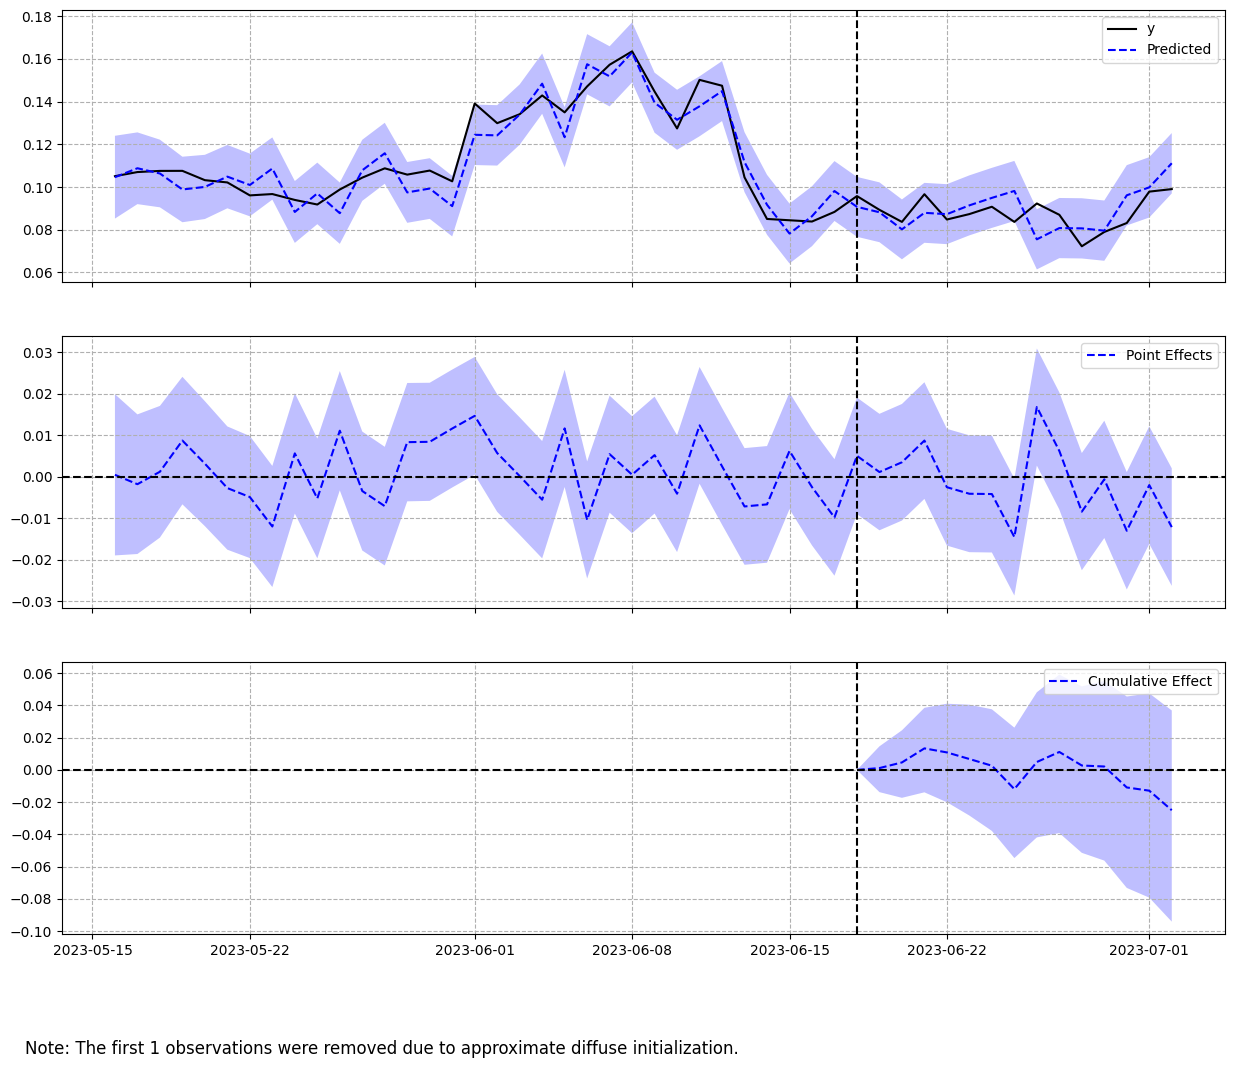

0.32667332667332666


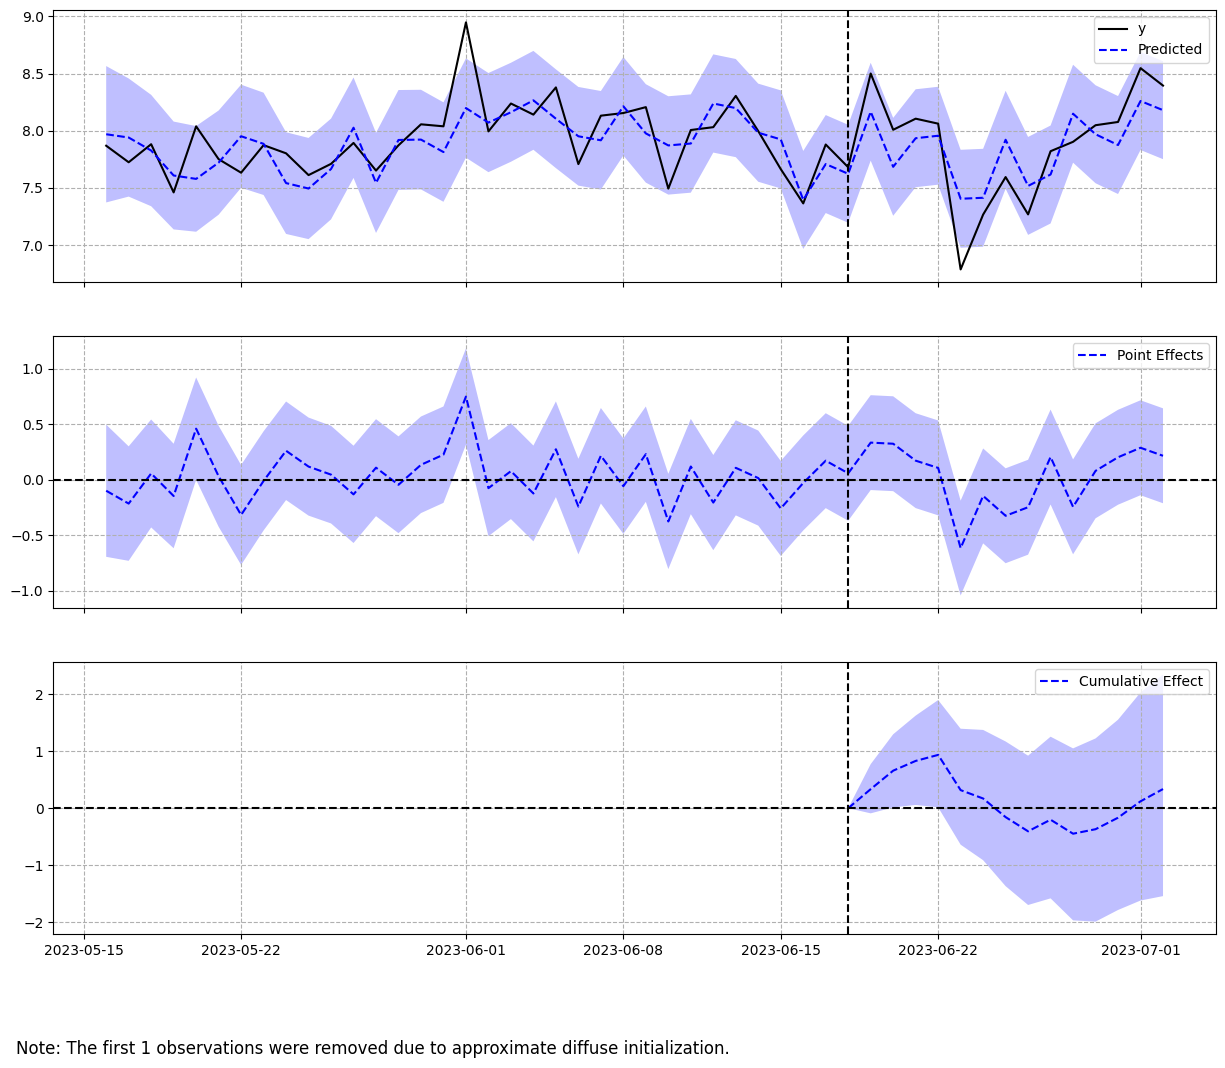

0.3386613386613387


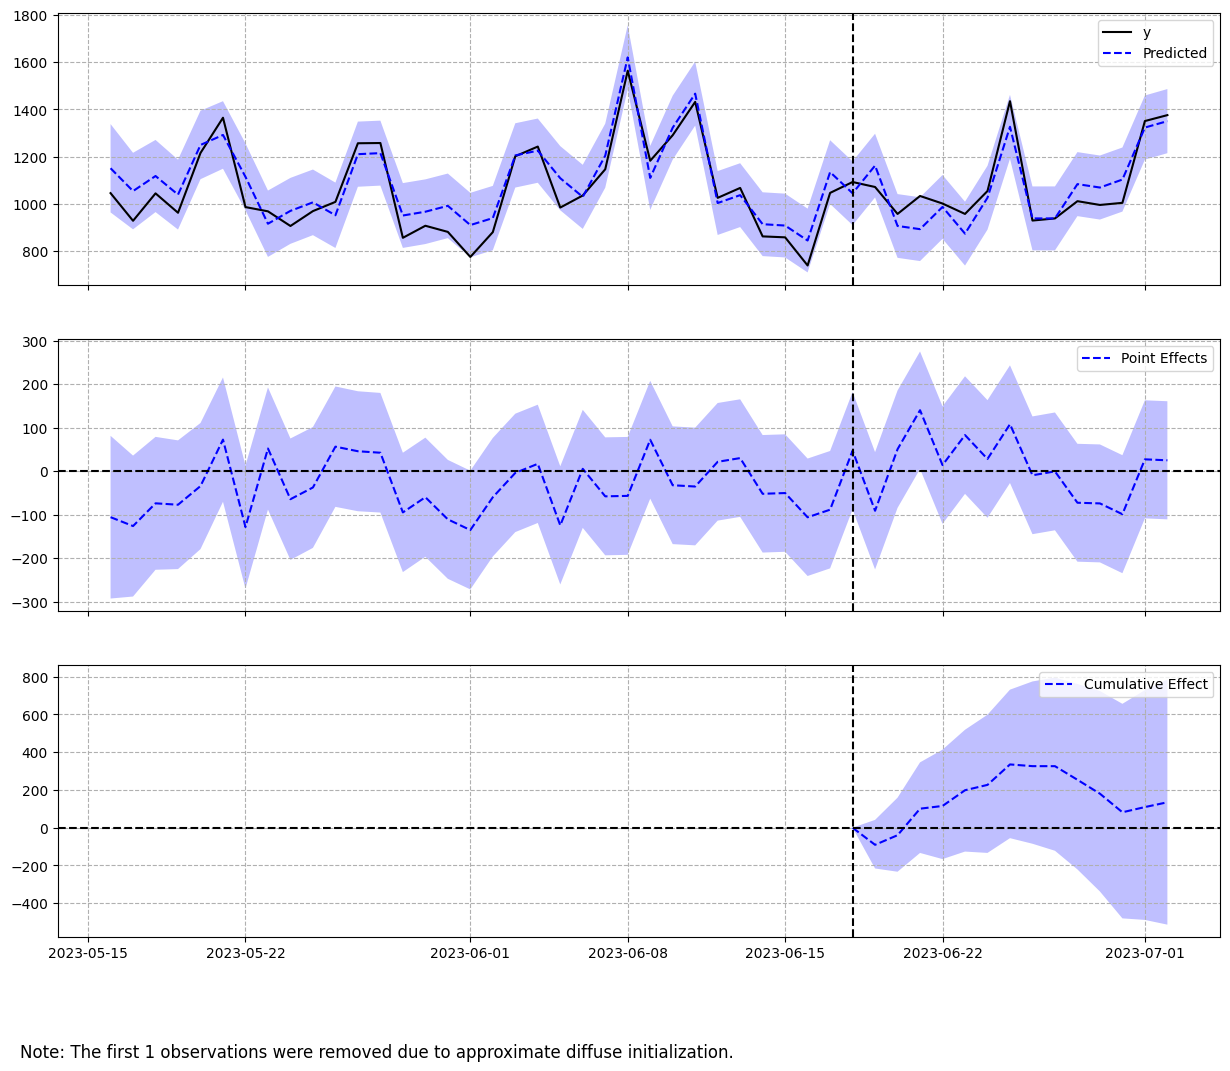

In [30]:

print_result = True
variable_names = ['perc_products_pna', 'avg_UIPO', 'number_of_orders']
key = 2	

for variable_name in variable_names:
    print(results_dict[variable_name][key]['model'].p_value)
    results_dict[variable_name][key]['model'].plot()
    
# Function to output configuration    
if print_result:
    data = json.loads(results_dict[variable_names[0]][key]['df_groups_json'])

    # Extract the columns and data from the JSON
    columns = data["columns"]
    rows = data["data"]
    output_csv = "XXX.csv"

    # Write the data to CSV
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(columns) # Write the header row
        writer.writerows(rows) # Write the data rows